In [2]:
import torch
import gc
from pathlib import Path
import os
import tqdm
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import random
# import transformer_lens
from transformers import BertTokenizer, BertModel, AutoModel, AutoModelForMaskedLM

from transformers import utils
utils.logging.set_verbosity_error()

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_orig = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

bert_tiny = AutoModel.from_pretrained("prajjwal1/bert-tiny", output_attentions=True)
bert_small = AutoModel.from_pretrained("prajjwal1/bert-small", output_attentions=True)
bert_med = AutoModel.from_pretrained("prajjwal1/bert-medium", output_attentions=True)

# tokenizer_large = AutoTokenizer.from_pretrained("bert-large-uncased")
bert_large = AutoModelForMaskedLM.from_pretrained("bert-large-uncased", output_attentions=True)

In [5]:
model_list = [bert_tiny, bert_small, bert_med, bert_large]
model_names = ['BERT Tiny', 'BERT Small', 'BERT Medium', 'BERT Large']

In [6]:
sample_attn = bert_med(torch.randint(0, 10, (1, 5))).attentions

## Generating induction maps for other model sizes

BERT Tiny


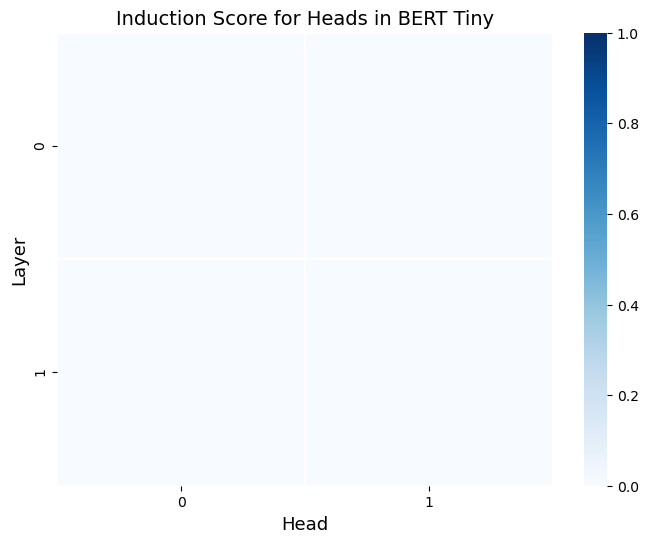

BERT Small


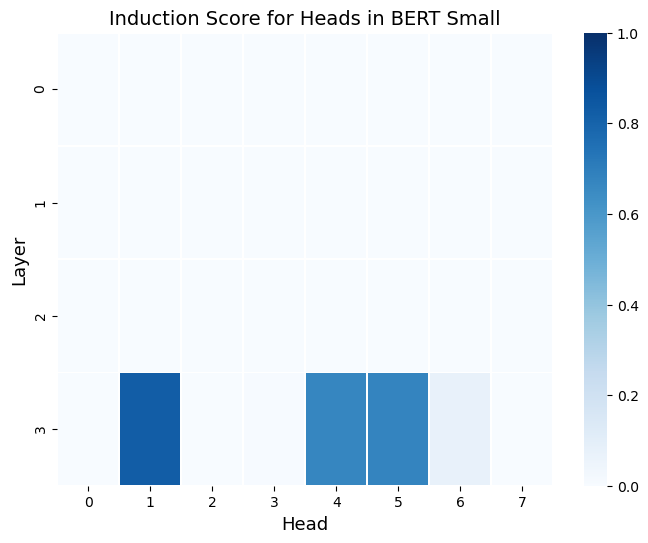

BERT Medium


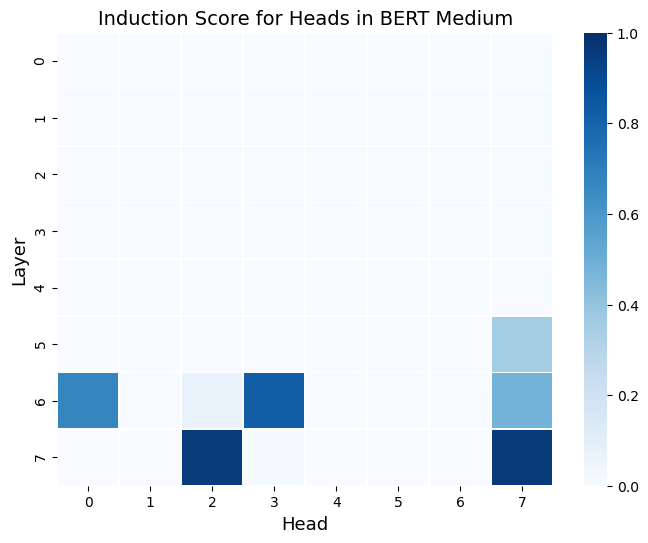

BERT Large


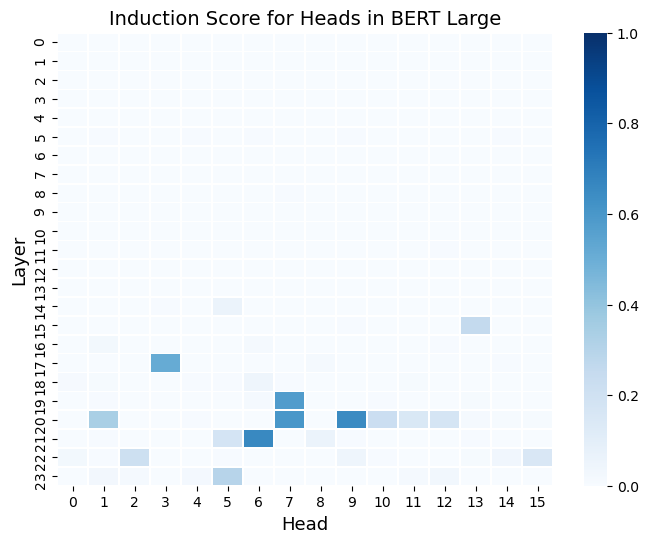

In [10]:
num_trials = 50
seq_len = 200

batch_size = 1
sep_token = 102 # [SEP] token id

for i in range(len(model_list)):
    
    m = model_list[i]
    model_name = model_names[i]
    print(model_name)
    
    sample_attn = m(torch.randint(0, 10, (1, 5))).attentions
    n_heads = len(sample_attn)
    n_layers = len(sample_attn[0][0])
    
    induction_score_store = torch.zeros((n_heads, n_layers), dtype=torch.float32)
    
    for i in range(num_trials):

        # generate RRT
        rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
        rep_tokens = torch.cat(
            [
                torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
                rand_tokens,
                rand_tokens,
            ],
            dim=1,
        )

        # Select random token to mask
        rand_ind = random.randint(0, seq_len - 1)
        mask_ind = seq_len + rand_ind # + 1
        rep_tokens[0][mask_ind] = 103

        output = m(rep_tokens)
        
        batch = 0
        for layer in range(n_heads):
            for head in range(n_layers):
                attn = output.attentions[layer][batch][head]
                mask_attn = attn[mask_ind]
                induction_score_store[layer][head] += (mask_attn[rand_ind])

    ind_scores_np = induction_score_store.detach().numpy() / num_trials

    fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
    s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
    s.set_xlabel('Head', fontsize=13)
    s.set_ylabel('Layer', fontsize=13)
    plt.title('Induction Score for Heads in ' + model_name, fontsize = 14)
    plt.savefig('figs/ind_map' + model_name, dpi = 150)
    plt.show()